# INTRODUCTION

This project illustrates the detection and tracking of vehicles using Kalman Filter. Following operations are performed in this analysis:

1. Prediction of current and future location of the vehicle.
2. Correcting the prediction as per the new measurements attained.
3. Optimizing the noise created by faulty detections.


In this analysis, we detect and track multiple vehicles using a camera mounted inside a selfdriving car. The images captured by the camera are taken as the input. In the image, the car is captured and a bounding box is created around the car. The model “ssd_mobilenet_v1_coco” which is pretrained on MS COCO datset is used for the detection of car. 

The coordinates of all four corners of the bounding are noted and state of the vehicle is determined at a particular time. Here, the rate of change of position gives the velocity. We consider the velocity as constant in the analysis. (Hence, acceleration is zero.)

Then, we implement Kalman filter to perform two main operations:

1. Prediction of objects current location using the previous states.
2. In update, current measurements are used to correct the state.



# STATE EQUATIONS

The general linear dynamic system's state equation used is of the form: 
$x_k = x_{k-1} + u_{k-1} \Delta t + 0.5 * a_{k-1} * \Delta t^2$



where,

$x_k$ = state at a given time stamp 'k'  (current state)

$x_{k-1}$ = = state at a given time 'k-1' (prior state)

$\Delta t $ is change in time

u is the velocity at time 'k-1'   (which is controlling the satates)

a is acceleration at time 'k-1'


In this analysis, we consider the object travelling in 2-D (both in X and Y direction).

Hence there will be state equations in terms of x and y.



Here, we are considering the four corners of the bounding box. 

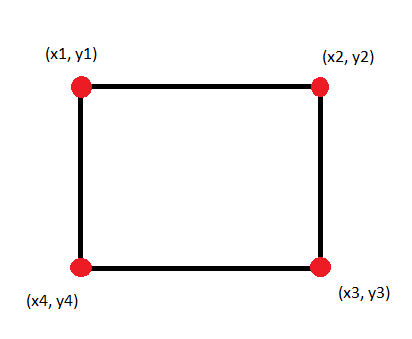

In a X-Y plane: 

y1 = y2 ; y4 = y3 (since the pair of points are on same horizontal line)

x1 = x4 ; x2 = x3 (since the pair of points are on same verticle line)

Hence, there will be four state equtions:

$x_{1, k} = x_{1, k-1} + u_{1,k-1} \Delta t $ 

$x_{2, k} = x_{2, k-1} + u_{2,k-1} \Delta t $

$y_{1, k} = y_{1, k-1} + u_{1,k-1} \Delta t $

$y_{1, k} = y_{1, k-1} + u_{1,k-1} \Delta t $

(As already mentioned acceletaion term is zero, since velocity os considered constant.)

Where u is velocity at k-1 timestamp

The state equation are always paired wih measurement equations, that describes the relationship between state and measurement at the current time stamp k.

The corresponding equations are obtained by taking the first derivative of staes with respect to time:

$ z_{x1, k} = u_{x1,k-1} $

$ z_{x2, k} = u_{x2,k-1} $

$ z_{y1, k} = u_{y1,k-1} $

$ z_{y2, k} = u_{y2,k-1} $


Where u is velocity at k-1 timestamp


### Notations:

X - State Mean

P - State Covariance

F - State Transition Matrix

Q - Process Covariance

B - Control Function

u - Control Input


Here, Q consists of the variances associated with each of the state estimates as well as the correlation between the errors in the state estimates.
$Q = \begin{bmatrix} 
  \Delta t^4 / 4   &\Delta t^3 / 2 \\
  \Delta t^3 / 2   &\Delta t^2  \\
  \end{bmatrix}$

All the variables and their respective coeffecients are grouped in the form of a matrices:

1. State Transition matrix: $F = \begin{bmatrix} 
  1 &\Delta t &0 &0 &0 &0 &0 &0 \\
  0 &1 &0 &0 &0 &0 &0 &0 \\
  0 &0 &1 &\Delta t &0 &0 &0 &0 \\
  0 &0 &0 &1 &0 &0 &0 &0 \\
  0 &0 &0 &0 &1 &\Delta t &0 &0 \\
  0 &0 &0 &0 &0 &1 &0 &0 \\
  0 &0 &0 &0 &0 &0 &1 &\Delta t \\
  0 &0 &0 &0 &0 &0 &0 &1
  \end{bmatrix}$
  This contains all the coffecients of state equation.


2. Measurement matrix: $B = \begin{bmatrix} 
  1 &0 &0 &0 &0 &0 &0 &0 \\
  0 &0 &1 &0 &0 &0 &0 &0 \\
  0 &0 &0 &0 &1 &0 &0 &0 \\
  0 &0 &0 &0 &0 &0 &1 &0 \\
  \end{bmatrix}$
  This is also known as Control matrix, which contains all the coeffecients of measurement equation




### ***Prediction phase equations***:

$\bar{x} = Fx + Bu$, where 

u = control input matrix

$\bar{P} = FPF^T + Q$


Here, 

 $Fx = \begin{bmatrix}
  y_{1,k-1} + u_{y1,k-1} \Delta t \\
  u_{y1,k-1} \\
  x_{1 k-1} + u_{x1,k-1} \Delta t \\
  u_{x1,k-1} \\
  y_{2,k-1} + u_{y2,k-1} \Delta t \\
  u_{y2,k-1} \\
  x_{2,k-1} + u_{x2,k-1} \Delta t \\
  u_{x2,k-1}
  \end{bmatrix}$,

  
  
  $ Bu = \begin{bmatrix} y_{1 k-1} \\ x_{1 k-1} \\ y_{2 k-1} \\x_{2 k-1}\end{bmatrix}$.


### ***Update phase equations***:

H - Measurement matrix

z - measurement

R - measiurement noise covariance

y - reisdual

K - Klaman gain   


Here, 

H is a transformation matrix that transforms the state into the measurement domain

Klaman gain is just a weight given to the measurements and the current state estimates)

Residual is difference between the measurement and the value predicted by the filter.



$y = z - H\bar{x}$

$K =  \bar{P}H^T(H\bar{P}H^T + R)^-1 $ 

$x =  \bar{x} + Ky $ 

$P = (I - KH)\bar{P}$


# INSTALLING THE REQUIRED PACKAGES

In [ ]:
#installing packages
!pip install fastai
!pip install -Uqq fastbook
!pip install matplotlib-venn

# Cloning Github link to google colab File folder:

# Implementation and test car detection

In this phase of the analysis, the images/frames are taken as input. By using the model 'ssd_mobilenet_v1_coco' model, car is detected in the image and bounding boxes are formed, which is output. The coordinate axes of four corners of the box are considered and states are defined in futher analysis.

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from matplotlib import pyplot as plt
import time
from glob import glob

cwd = os.path.dirname(os.path.realpath('E:\\maths project\\VehicleVision\\test_images'))

class CarDetector(object):
    def __init__(self):

        self.car_boxes = []
        
        os.chdir(cwd)
        
        # Tensorflow localization/detection model
        # Single-shot-dectection with mobile net architecture trained on COCO dataset
        
        detect_model_name = 'E:\\maths project\\VehicleVision\\Pre Trained Model'

        PATH_TO_CKPT = detect_model_name + '\\frozen_inference_graph.pb'
        
        # setup tensorflow graph
        self.detection_graph = tf.Graph()
        
        # configuration for possible GPU use
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        # load frozen tensorflow detection model and initialize 
        # the tensorflow graph
        with self.detection_graph.as_default():
          od_graph_def = tf.compat.v1.GraphDef()
          with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
               
            self.sess = tf.compat.v1.Session(graph=self.detection_graph, config=config)
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
              # Each box represents a part of the image where a particular object was detected.
            self.boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
              # Each score represent how level of confidence for each of the objects.
              # Score is shown on the result image, together with the class label.
            self.scores =self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_detections =self.detection_graph.get_tensor_by_name('num_detections:0')
    
    # Helper function to convert image into numpy array    
    def load_image_into_numpy_array(self, image):
         (im_width, im_height) = image.size
         return np.array(image.getdata()).reshape(
            (im_height, im_width, 3)).astype(np.uint8)       
    # Helper function to convert normalized box coordinates to pixels
    def box_normal_to_pixel(self, box, dim):
    
        height, width = dim[0], dim[1]
        box_pixel = [int(box[0]*height), int(box[1]*width), int(box[2]*height), int(box[3]*width)]
        return np.array(box_pixel)       
        
    def get_localization(self, image, visual=False):  
        
        """Determines the locations of the cars in the image

        Args:
            image: camera image

        Returns:
            list of bounding boxes: coordinates [y_up, x_left, y_down, x_right]

        """
        category_index={1: {'id': 1, 'name': u'person'},
                        2: {'id': 2, 'name': u'bicycle'},
                        3: {'id': 3, 'name': u'car'},
                        4: {'id': 4, 'name': u'motorcycle'},
                        5: {'id': 5, 'name': u'airplane'},
                        6: {'id': 6, 'name': u'bus'},
                        7: {'id': 7, 'name': u'train'},
                        8: {'id': 8, 'name': u'truck'},
                        9: {'id': 9, 'name': u'boat'},
                        10: {'id': 10, 'name': u'traffic light'},
                        11: {'id': 11, 'name': u'fire hydrant'},
                        13: {'id': 13, 'name': u'stop sign'},
                        14: {'id': 14, 'name': u'parking meter'}}  
        
        # The following code snippet implements the actual detection using TensorFlow API.

        with self.detection_graph.as_default():
              image_expanded = np.expand_dims(image, axis=0)
              (boxes, scores, classes, num_detections) = self.sess.run(
                  [self.boxes, self.scores, self.classes, self.num_detections],
                  feed_dict={self.image_tensor: image_expanded})

        # Here boxes, scores, and classes represent the bounding box, confidence level, and class name corresponding to each of the detection, respectively. 
        # In the next step, we select the detections that are cars and have a confidence greater than a threshold ( e.g., 0.3 in this case).


              if visual == True:
                  vis_util.visualize_boxes_and_labels_on_image_array(
                      image,
                      np.squeeze(boxes),
                      np.squeeze(classes).astype(np.int32),
                      np.squeeze(scores),
                      category_index,
                      use_normalized_coordinates=True,min_score_thresh=.4,
                      line_thickness=3)
    
                  plt.figure(figsize=(9,6))
                  plt.imshow(image)
                  plt.show()  
              
              boxes=np.squeeze(boxes)
              classes =np.squeeze(classes)
              scores = np.squeeze(scores)
    
              cls = classes.tolist()
              
              # The ID for car in COCO data set is 3 
              idx_vec = [i for i, v in enumerate(cls) if ((v==3) and (scores[i]>0.3))]
              
              if len(idx_vec) ==0:
                  print('no detection!')
                  self.car_boxes = []  
              else:
                  tmp_car_boxes=[]
                  for idx in idx_vec:
                      dim = image.shape[0:2]
                      box = self.box_normal_to_pixel(boxes[idx], dim)
                      box_h = box[2] - box[0]
                      box_w = box[3] - box[1]
                      ratio = box_h/(box_w + 0.01)


                      #To further reduce possible false positives, we include thresholds for bounding box width, height, and height-to-width ratio.
                      
                      if ((ratio < 0.8) and (box_h>20) and (box_w>20)):
                          tmp_car_boxes.append(box)
                          print(box, ', confidence: ', scores[idx], 'ratio:', ratio)
                         
                      else:
                          print('wrong ratio or wrong size, ', box, ', confidence: ', scores[idx], 'ratio:', ratio)
                          
                          
                  
                  self.car_boxes = tmp_car_boxes
             
        return self.car_boxes
        
if __name__ == '__main__':
        # Test the performance of the detector
        det =CarDetector()
        os.chdir(cwd)
        TEST_IMAGE_PATHS= glob(os.path.join('E:\\maths project\\VehicleVision\\test_images\\', '*.jpg'))
        
        for i, image_path in enumerate(TEST_IMAGE_PATHS[0:2]):
            print('')
            print('*************************************************')
            
            img_full = Image.open(image_path)
            img_full_np = det.load_image_into_numpy_array(img_full)
            img_full_np_copy = np.copy(img_full_np)
            start = time.time()
            b = det.get_localization(img_full_np, visual=False)
            end = time.time()
            print('Localization time: ', end-start)
#            
            

# Helper classes and functions for detection and tracking

In [ ]:
import cv2
class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()

def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.;
    l2 = x2 - w2 / 2.;
    left = max(l1, l2)
    r1 = x1 + w1 / 2.;
    r2 = x2 + w2 / 2.;
    right = min(r1, r2)
    return right - left;

def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w);
    h = overlap(a.y, a.h, b.y, b.h);
    if w < 0 or h < 0: return 0;
    area = w * h;
    return area;

def box_union(a, b):
    i = box_intersection(a, b);
    u = a.w * a.h + b.w * b.h - i;
    return u;

def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b);

def box_iou2(a, b):
    '''
    Helper funciton to calculate the ratio between intersection and the union of
    two boxes a and b
    a[0], a[1], a[2], a[3] <-> left, up, right, bottom
    '''
    
    w_intsec = np.maximum (0, (np.minimum(a[2], b[2]) - np.maximum(a[0], b[0])))
    h_intsec = np.maximum (0, (np.minimum(a[3], b[3]) - np.maximum(a[1], b[1])))
    s_intsec = w_intsec * h_intsec
    s_a = (a[2] - a[0])*(a[3] - a[1])
    s_b = (b[2] - b[0])*(b[3] - b[1])
  
    return float(s_intsec)/(s_a + s_b -s_intsec)

def convert_to_pixel(box_yolo, img, crop_range):
    
    box = box_yolo
    imgcv = img
    [xmin, xmax] = crop_range[0]
    [ymin, ymax] = crop_range[1]
    h, w, _ = imgcv.shape
    
    # Calculate left, top, width, and height of the bounding box
    left = int((box.x - box.w/2.)*(xmax - xmin) + xmin)
    top = int((box.y - box.h/2.)*(ymax - ymin) + ymin)
    
    width = int(box.w*(xmax - xmin))
    height = int(box.h*(ymax - ymin))
    
    # Deal with corner cases
    if left  < 0    :  left = 0
    if top   < 0    :   top = 0
    
    # Return the coordinates (in the unit of the pixels)
  
    box_pixel = np.array([left, top, width, height])
    return box_pixel



def convert_to_cv2bbox(bbox, img_dim = (1280, 720)):
    '''
    Helper fucntion for converting bbox to bbox_cv2
    bbox = [left, top, width, height]
    bbox_cv2 = [left, top, right, bottom]
    img_dim: dimension of the image, img_dim[0]<-> x
    img_dim[1]<-> y
    '''
    left = np.maximum(0, bbox[0])
    top = np.maximum(0, bbox[1])
    right = np.minimum(img_dim[0], bbox[0] + bbox[2])
    bottom = np.minimum(img_dim[1], bbox[1] + bbox[3])
    
    return (left, top, right, bottom)
    
    
def draw_box_label(img, bbox_cv2, box_color=(0, 255, 255), show_label=True):
    '''
    Helper funciton for drawing the bounding boxes and the labels
    bbox_cv2 = [left, top, right, bottom]
    '''
    #box_color= (0, 255, 255)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 0.7
    font_color = (0, 0, 0)
    left, top, right, bottom = bbox_cv2[1], bbox_cv2[0], bbox_cv2[3], bbox_cv2[2]
    
    # Draw the bounding box
    cv2.rectangle(img, (left, top), (right, bottom), box_color, 4)
    
    if show_label:
        # Draw a filled box on top of the bounding box (as the background for the labels)
        cv2.rectangle(img, (left-2, top-45), (right+2, top), box_color, -1, 1)
        
        # Output the labels that show the x and y coordinates of the bounding box center.
        text_x= 'x='+str((left+right)/2)
        cv2.putText(img,text_x,(left,top-25), font, font_size, font_color, 1, cv2.LINE_AA)
        text_y= 'y='+str((top+bottom)/2)
        cv2.putText(img,text_y,(left,top-5), font, font_size, font_color, 1, cv2.LINE_AA)
    
    return img    

# Implementing and test tracker

The operations - prediction and update take place in this phase. 

In prediction, the  thye previous statres are used to predict the current state. 
In update, the current measurement value (location of the bounding box) is used, to correct the state.

Here, we use the coordinates and their first-order derivatives of the up, down, left and right cornerx of the bounding box.

Assumptions:

Here, we are assuming the constant velocity (thus no acceleration).

Time interval is constant and is taken as 1

In [ ]:
from numpy import dot
from scipy.linalg import inv, block_diag
import glob


class Tracker():                                                                  # class for Kalman Filter-based tracker
    def __init__(self):
        # Initializing the parametes for tracker (history)
        self.id = 0                                                               # tracker's id 
        self.box = []                                                             # list to store the coordinates for a bounding box 
        self.hits = 0                                                             # number of detection matches
        self.no_losses = 0                                                        # number of unmatched tracks (track loss)
        
        # Initializing the parameters:
        self.x_state=[] 
        self.dt = 1.   # time interval
        
        # Process matrix:
        self.F = np.array([[1, self.dt, 0,  0,  0,  0,  0, 0],
                           [0, 1,  0,  0,  0,  0,  0, 0],
                           [0, 0,  1,  self.dt, 0,  0,  0, 0],
                           [0, 0,  0,  1,  0,  0,  0, 0],
                           [0, 0,  0,  0,  1,  self.dt, 0, 0],
                           [0, 0,  0,  0,  0,  1,  0, 0],
                           [0, 0,  0,  0,  0,  0,  1, self.dt],
                           [0, 0,  0,  0,  0,  0,  0,  1]])
        
        
        # Measurement matrix:
        
        self.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 1, 0, 0, 0], 
                           [0, 0, 0, 0, 0, 0, 1, 0]])
        
        
        # Initialing the state covariance:
        self.L = 10.0
        self.P = np.diag(self.L*np.ones(8))
        
        
        # Initializing the process covariance
        self.Q_comp_mat = np.array([[self.dt**4/4., self.dt**3/2.],
                                    [self.dt**3/2., self.dt**2]])
        self.Q = block_diag(self.Q_comp_mat, self.Q_comp_mat, 
                            self.Q_comp_mat, self.Q_comp_mat)
        
        # Initializing the measurement covariance
        self.R_scaler = 1.0
        self.R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(self.R_diag_array)


        # Here self.R_scaler represents the "magnitude" of measurement noise relative to state noise. 
        # A low self.R_scaler indicates a more reliable measurement. 
        
        
    def update_R(self):   
        R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(R_diag_array)
         
        
    def kalman_filter(self, z): 
        
        # Implementing the Kalman Filter, including the predict and the update stages, with the measurement z
        
        x = self.x_state
        
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q

        #Update
        S = dot(self.H, self.P).dot(self.H.T) + self.R
        K = dot(self.P, self.H.T).dot(inv(S)) # Kalman gain
        y = z - dot(self.H, x) # residual
        x += dot(K, y)
        self.P = self.P - dot(K, self.H).dot(self.P)
        self.x_state = x.astype(int) # converting to integer coordinates 
                                     #(pixel values)
        
    def predict_only(self):  

        # Implment only the predict stage. 
        # This is used for unmatched detections and unmatched tracks.

        x = self.x_state
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q
        self.x_state = x.astype(int)
        
if __name__ == "__main__":

    
    # Creat an instance
    trk = Tracker() 
    # Test R_ratio   
    trk.R_scaler = 1.0/16
    # Update measurement noise covariance matrix
    trk.update_R()
    # Initial state
    x_init = np.array([390, 0, 1050, 0, 513, 0, 1278, 0])
    x_init_box = [x_init[0], x_init[2], x_init[4], x_init[6]]
    # Measurement
    z=np.array([399, 1022, 504, 1256])
    trk.x_state= x_init.T
    trk.kalman_filter(z.T)
    # Updated state
    x_update =trk.x_state
    x_updated_box = [x_update[0], x_update[2], x_update[4], x_update[6]]
    
    print('The initial state is: ', x_init)
    print('The measurement is: ', z)
    print('The update state is: ', x_update)
    
    # Visualize the Kalman filter process and the 
    # impact of measurement nosie convariance matrix

    images = [plt.imread(file) for file in glob.glob('E:\\maths project\\VehicleVision\\test_images\\*.jpg')]
    
    img = images[1]
    plt.figure(figsize=(10, 14))


    # changed here
    #helpers.draw_box_label(img, x_init_box, box_color=(0, 255, 0))
    # draw_box_label(img, x_init_box, box_color=(0, 255, 0))
    draw_box_label(img.copy(), x_init_box, box_color=(0, 255, 0))
    ax = plt.subplot(3, 1, 1)
    plt.imshow(img)
    plt.title('Initial: '+str(x_init_box))

    
    # changed here
    #helpers.draw_box_label(img, z, box_color=(255, 0, 0))
    draw_box_label(img.copy(), z, box_color=(255, 0, 0))
    ax = plt.subplot(3, 1, 2)
    plt.imshow(img)
    plt.title('Measurement: '+str(z))
    
    #helpers.draw_box_label(img, x_updated_box)
    draw_box_label(img.copy(), x_updated_box)
    ax = plt.subplot(3, 1, 3)
    plt.imshow(img)
    plt.title('Updated: '+str(x_updated_box))
    plt.show()    

# **OBSERVATION:**

From the above output images, we can visualize the measurement noises in the Kalman filter process. 

The green bounding box gives the initial state of the car. 
The red bounding box gives the measurement values.
The aqua colored bounding box give sthe updated state. 

Here, the initial state value is 390
The measurement state value is 399 afetr 1 second
Updated state value is 398

If measurement noise is low, the updated state is very close to the measurement. So, the aqua bounding box completely overlaps the red bounding box.

Suppose, if measurement noise is high, the updated state is very close to the initial prediction. So, the aqua bounding box completely overlaps over the green bounding box.

From the output images, there is no complete overlapping of green and aqua bounding box. Which infers that the measurement noise is relatively lower.



# ***MAIN functions***

These functions, implementt the detection and tracking, including detection-track assignment and track management:

In the below logic, the section assign_detections_to_trackers(trackers, detections, iou_thrd = 0.3) takes from current list of trackers and new detections, output matched detections, unmatched trackers, unmatched detections.

**HUNGARIAN ALGORITHM:**

The Hungarian method is a combinatorial optimization algorithm that solves the assignment problem in polynomial time and which anticipated later primal–dual methods.
(https://en.wikipedia.org/wiki/Hungarian_algorithm)


EXAMPLE:

Consider a company has 4 employees and there are four jobs to be done. Here, each employee is capable of doing any of the four jobs. But, the time taken to complete the work is different for different employees. Then Hungarian Algorithm concept is applied and the jobs are assigned to the emplyees in effecient manner so as to control the time and cost of the assignment.

Here, the analysis is carried out by taking all the values of time taken by the employees for different jobs into a tablular format or in form of matrix (cost matrix) and operations are performed till we optimise the assignment.

In the cost matrix, if a constant is added to every element of a row or a column, the optimum solution of the resulting assignment problem is the same as the original problem.

In this analysis, we implement Linear Assignment and Hungarian (Munkres) algorithm:


If multiple detections are identified, we need to assign each of them to a tracker. Here, we are using intersection over union (IOU) of a 'tracker bounding box' and 'detection bounding box' as a metric. 
Here, we analyse till maximizing/optimizing the sum of IOU assignment.



In the below logic, linear_assignment by default minimizes an objective function. So we need to reverse the sign of IOU_mat for maximization.

**Unmatched detections and trackers:**


Depending on the results of linear assignment, we make lists for unmatched detections and unmatched trackers. 



When a car enters into a frame and is first detected, it is not matched with any existing tracks. Hence this particular detection is categorized under unmatched detection. If any matching with an overlap less than iou_thrd, it denotes the existence of an untracked object. When the car leaves the frame, 
the previous used track has no more detections to consider. So, the track is considered as an unmatched track.

In this way, the tracker and the detection associated in the matching are added to the lists of unmatched trackers and unmatched detection.

We include two important design parameters, min_hits and max_age, in the pipeline. The parameter min_hits is the number of consecutive matches needed to establish a track. The parameter max_age is number of consecutive unmatched detections before a track is deleted. Both parameters need to be tuned to improve the tracking and detection performance.

In [ ]:

from moviepy.editor import VideoFileClip
from collections import deque
from scipy.optimize import linear_sum_assignment as linear_assignment


frame_count = 0               # frame counter

max_age = 4                   # number of consecutive unmatched detection before the track is deleted

min_hits =1                   # number of consecutive matches needed to establish a track

tracker_list =[]              # list for trackers

track_id_list= deque(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])              # list for track ID

debug = True

def assign_detections_to_trackers(trackers, detections, iou_thrd = 0.3):
    IOU_mat= np.zeros((len(trackers),len(detections)),dtype=np.float32)
    for t,trk in enumerate(trackers):
        #trk = convert_to_cv2bbox(trk) 
        for d,det in enumerate(detections):
         #   det = convert_to_cv2bbox(det)
            IOU_mat[t,d] = box_iou2(trk,det) 
           
    # Here, we are using the Hungarian algorithm to solve the maximizing the sum of IOU assignment problem.
    
    matched_idx = linear_assignment(-IOU_mat)
    matched_idx = np.asarray(matched_idx)
    matched_idx = np.transpose(matched_idx)        

    unmatched_trackers, unmatched_detections = [], []
    for t,trk in enumerate(trackers):
        if(t not in matched_idx[:,0]):
            unmatched_trackers.append(t)

    for d, det in enumerate(detections):
        if(d not in matched_idx[:,1]):
            unmatched_detections.append(d)

    matches = []
   
    # To create trackers we consider any detection with an overlap less than iou_thrd to signifiy the existence of an untracked object
    
    for m in matched_idx:
        if(IOU_mat[m[0],m[1]]<iou_thrd):
            unmatched_trackers.append(m[0])
            unmatched_detections.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    
    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)       
    


def pipeline(img):
    global frame_count
    global tracker_list
    global max_age
    global min_hits
    global track_id_list
    global debug
    
    frame_count+=1
    
    img_dim = (img.shape[1], img.shape[0])
    z_box = det.get_localization(img) # measurement
    if debug:
       print('Frame:', frame_count)
       
    x_box =[]
    if debug: 
        for i in range(len(z_box)):
           img1= draw_box_label(img.copy(), z_box[i], box_color=(255, 0, 0))
           plt.imshow(img1)
        plt.show()
    
    if len(tracker_list) > 0:
        for trk in tracker_list:
            x_box.append(trk.box)
    
    
    matched, unmatched_dets, unmatched_trks \
    = assign_detections_to_trackers(x_box, z_box, iou_thrd = 0.3)  
    if debug:
         print('Detection: ', z_box)
         print('x_box: ', x_box)
         print('matched:', matched)
         print('unmatched_det:', unmatched_dets)
         print('unmatched_trks:', unmatched_trks)
    
         
    # Working on matched detections  
    # When the car is detected again in the second video frame, running the following assign_detections_to_trackers returns an one-element list , an empty list, 
    # for matched, unmatched_dets, and unmatched_trks, respectively.

    if matched.size >0:
        for trk_idx, det_idx in matched:
            z = z_box[det_idx]
            z = np.expand_dims(z, axis=0).T
            tmp_trk= tracker_list[trk_idx]
            tmp_trk.kalman_filter(z)
            xx = tmp_trk.x_state.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            x_box[trk_idx] = xx
            tmp_trk.box =xx
            tmp_trk.hits += 1
            tmp_trk.no_losses = 0

    # The above code block carries out two important tasks, 
    # 1) carrying out the Kalman filter's prediction and update stages using the function tmp_trk.kalman_filter(); 
    # 2) increasing the hits of the track by one tmp_trk.hits +=1. 
    
    # In our analysis, trk.hits >= min_hits and trk.no_losses <=max_age.  So the track is fully established. As the result, the bounding box is annotated in the output image



    
    # Working on  unmatched detections 
    # if len(unmatched_dets)>0:
    #     for idx in unmatched_dets:
    #         z = z_box[idx]
    #         z = np.expand_dims(z, axis=0).T
    #         tmp_trk = Tracker() # Creating a new tracker
    #         x = np.array([[z[0], 0, z[1], 0, z[2], 0, z[3], 0]]).T
    #         tmp_trk.x_state = x
    #         # x = np.array([[z[0], 0, z[1], 0, z[2], 0, z[3], 0]]).T
    #         # tmp_trk.x_state = np.reshape(tmp_trk.x_state, x.shape)
    #         # tmp_trk.x_state = x
    #         tmp_trk.predict_only()
    #         xx = tmp_trk.x_state
    #         xx = xx.T[0].tolist()
    #         xx =[xx[0], xx[2], xx[4], xx[6]]
    #         tmp_trk.box = xx
    #         tmp_trk.id = track_id_list.popleft() 
    #         tracker_list.append(tmp_trk)
    #         x_box.append(xx)
    if len(unmatched_dets) > 0:
        for idx in unmatched_dets:
            z = z_box[idx]
            z = np.array([z[0], 0, z[1], 0, z[2], 0, z[3], 0]).reshape((8, 1))
            tmp_trk = Tracker()  # Creating a new tracker
            tmp_trk.x_state = z
            tmp_trk.predict_only()
            xx = tmp_trk.x_state
            xx = xx.T[0].tolist()
            xx = [xx[0], xx[2], xx[4], xx[6]]
            tmp_trk.box = xx
            tmp_trk.id = track_id_list.popleft()
            tracker_list.append(tmp_trk)
            x_box.append(xx)

    
    # Working with unmatched tracks       
    if len(unmatched_trks)>0:
        for trk_idx in unmatched_trks:
            tmp_trk = tracker_list[trk_idx]
            tmp_trk.no_losses += 1
            tmp_trk.predict_only()
            xx = tmp_trk.x_state
            xx = xx.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            tmp_trk.box =xx
            x_box[trk_idx] = xx
                   
       
    # The list of tracks that are to be annotated: 
    good_tracker_list =[]
    for trk in tracker_list:
        if ((trk.hits >= min_hits) and (trk.no_losses <=max_age)):
             good_tracker_list.append(trk)
             x_cv2 = trk.box
             if debug:
                 print('updated box: ', x_cv2)
                 print()
             img= draw_box_label(img.copy(), x_cv2)  # Drawing the bounding boxes

    deleted_tracks = filter(lambda x: x.no_losses >max_age, tracker_list)  
    
    for trk in deleted_tracks:
            track_id_list.append(trk.id)
    
    tracker_list = [x for x in tracker_list if x.no_losses<=max_age]
    
    if debug:
       print('Ending tracker_list: ',len(tracker_list))
       print('Ending good tracker_list: ',len(good_tracker_list))
    
       
    return img
    
if __name__ == "__main__":
  det = CarDetector()
  start=time.time()
  output = 'test_v7.mp4'
  clip1 = VideoFileClip("project_video.mp4")     
  clip = clip1.fl_image(pipeline)
  clip.write_videofile(output, audio=False)
  end  = time.time()
    
#     print(round(end-start, 2), 'Seconds to finish')
#   if debug: # testing on images
#         images = [plt.imread(file) for file in glob.glob('E:\\maths project\\VehicleVision\\test_images\\*.jpg')]
        
#         for i in range(len(images))[0:7]:
#              image = images[i]
#              image_box = pipeline(image)   
#              plt.imshow(image_box)
#              plt.show()
#   else:                         # test on a video file.
#     start=time.time()
#     output = 'test_v7.mp4'
#     clip1 = VideoFileClip("project_video.mp4")     
#     clip = clip1.fl_image(pipeline)
#     clip.write_videofile(output, audio=False)
#     end  = time.time()
    
#     print(round(end-start, 2), 'Seconds to finish')

From all the above output images, the condition trk.hits >= the number of consecutive matches need for track establishment and trk.no_losses <= the number of cosecutive unmatched detections before a track is deleted. Hence the track is fully established. 

As the result, the bounding box is created in the output image, as shown in the above figure.

So, we have implemented the detection and tracking logic which includes detection track assignment and track management.
In this analysis, the detecter first localized the vehicles in each frame. Then the tracker is updated with detected results. Hence we predicted and updated the location based on the current state.
Or it can also be said as we have predicted the cars next position depending upon its previous position. We have also dealt with noise measurements by looking at how the boxes ovelap on eachother depending on the noise levels.



The model has performed pretty well and produced desirable results in prediction, measurement and updation, depending the assumptions taken into consideration.